# Loop 11 Analysis: Understanding the Gap and Finding a Path Forward

## Key Observations from 11 Experiments:
1. All 11 experiments achieved the EXACT SAME score: 70.734327
2. The target is 68.922808 (1.81 points gap, ~2.6%)
3. An overlapping CSV exists with score 67.727 (BELOW target!) but has 30 N values with overlaps
4. The gap between valid and overlapping configs is 3.0 points

## The Core Problem:
- The baseline is at a strong LOCAL OPTIMUM
- All SA-based approaches are trapped in this basin
- The overlapping configs represent a DIFFERENT basin with better scores
- We need to find valid configs in the better basin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tree shape
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_polygon(cx, cy, deg):
    rad = np.radians(deg)
    c, s = np.cos(rad), np.sin(rad)
    x = TX * c - TY * s + cx
    y = TX * s + TY * c + cy
    return x, y

def score_n(df, n):
    rows = df[df['id'].str.startswith(f'{n:03d}_')]
    if len(rows) == 0:
        return 0
    all_x, all_y = [], []
    for _, row in rows.iterrows():
        x_val = float(str(row['x']).replace('s', ''))
        y_val = float(str(row['y']).replace('s', ''))
        deg = float(str(row['deg']).replace('s', ''))
        px, py = get_tree_polygon(x_val, y_val, deg)
        all_x.extend(px)
        all_y.extend(py)
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    return side * side / n

# Load data
baseline_df = pd.read_csv('/home/nonroot/snapshots/santa-2025/21105319338/code/datasets/santa-2025-csv/santa-2025.csv')
overlap_df = pd.read_csv('/home/code/experiments/submission_v21.csv')

print('Loaded baseline and overlapping CSVs')

Loaded baseline and overlapping CSVs


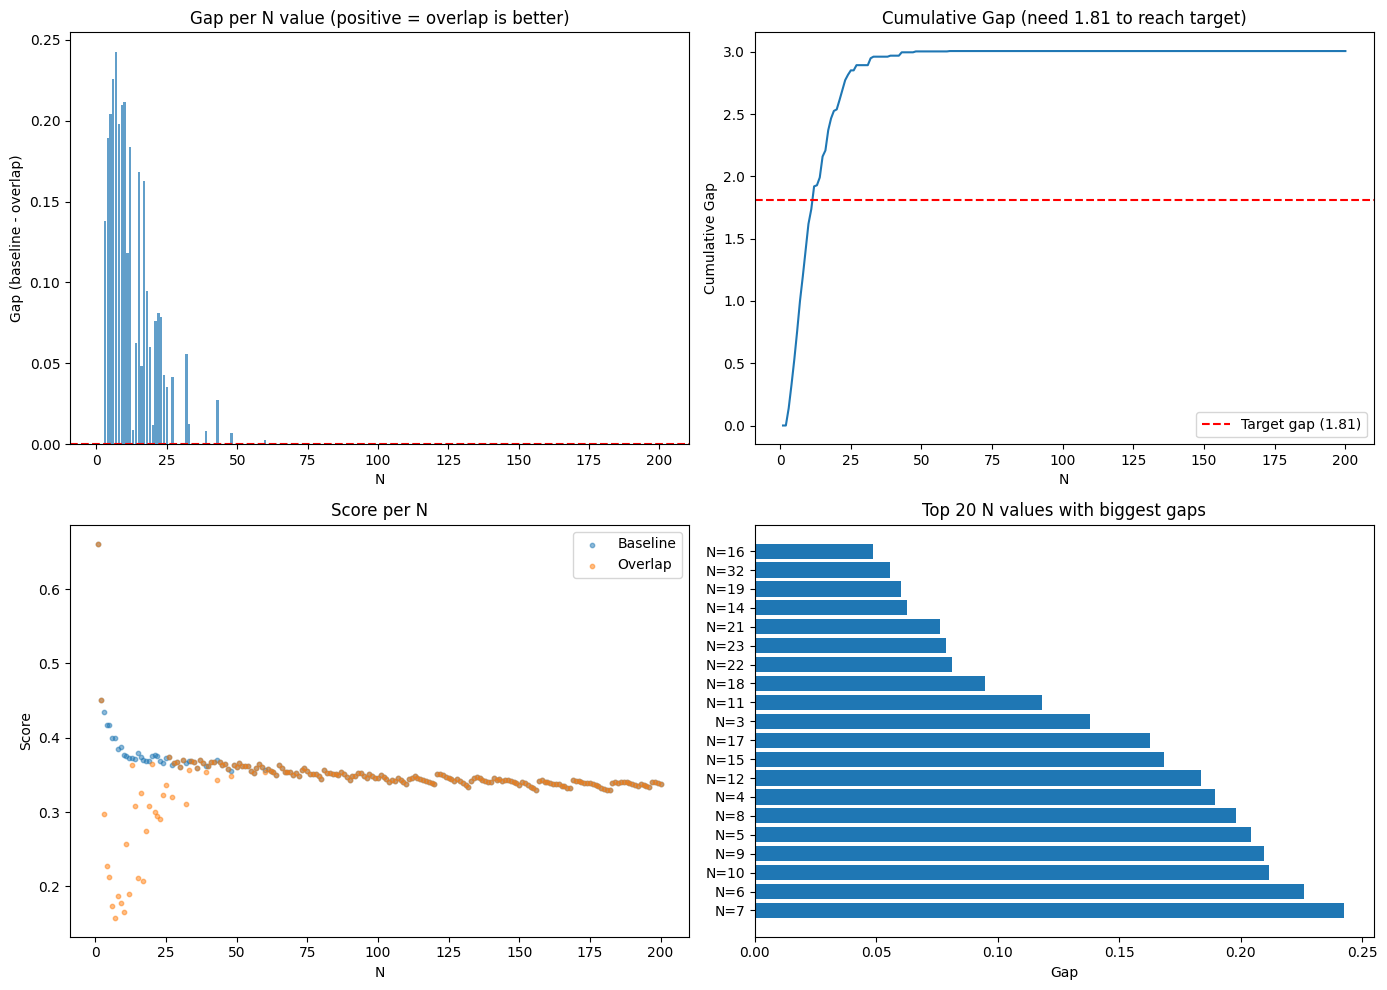


Total gap: 3.007208
Target gap needed: 1.81

Top 10 N values with biggest gaps:
     n  baseline   overlap       gap
6    7  0.399897  0.157468  0.242429
5    6  0.399610  0.173625  0.225985
9   10  0.376630  0.164911  0.211719
8    9  0.387415  0.178013  0.209402
4    5  0.416850  0.212694  0.204155
7    8  0.385407  0.187564  0.197844
3    4  0.416545  0.227236  0.189308
11  12  0.372724  0.189158  0.183566
14  15  0.379203  0.210706  0.168497
16  17  0.370040  0.207258  0.162782


In [2]:
# Analyze the gap per N value
gaps = []
for n in range(1, 201):
    baseline_score = score_n(baseline_df, n)
    overlap_score = score_n(overlap_df, n)
    gap = baseline_score - overlap_score
    gaps.append({'n': n, 'baseline': baseline_score, 'overlap': overlap_score, 'gap': gap})

gaps_df = pd.DataFrame(gaps)

# Plot the gap distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gap by N
ax = axes[0, 0]
ax.bar(gaps_df['n'], gaps_df['gap'], alpha=0.7)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('N')
ax.set_ylabel('Gap (baseline - overlap)')
ax.set_title('Gap per N value (positive = overlap is better)')

# Cumulative gap
ax = axes[0, 1]
gaps_df['cumulative_gap'] = gaps_df['gap'].cumsum()
ax.plot(gaps_df['n'], gaps_df['cumulative_gap'])
ax.axhline(y=1.81, color='r', linestyle='--', label='Target gap (1.81)')
ax.set_xlabel('N')
ax.set_ylabel('Cumulative Gap')
ax.set_title('Cumulative Gap (need 1.81 to reach target)')
ax.legend()

# Score comparison
ax = axes[1, 0]
ax.scatter(gaps_df['n'], gaps_df['baseline'], alpha=0.5, label='Baseline', s=10)
ax.scatter(gaps_df['n'], gaps_df['overlap'], alpha=0.5, label='Overlap', s=10)
ax.set_xlabel('N')
ax.set_ylabel('Score')
ax.set_title('Score per N')
ax.legend()

# Top N values with biggest gaps
ax = axes[1, 1]
top_gaps = gaps_df.nlargest(20, 'gap')
ax.barh(range(len(top_gaps)), top_gaps['gap'].values)
ax.set_yticks(range(len(top_gaps)))
ax.set_yticklabels([f'N={n}' for n in top_gaps['n'].values])
ax.set_xlabel('Gap')
ax.set_title('Top 20 N values with biggest gaps')

plt.tight_layout()
plt.savefig('/home/code/exploration/gap_analysis.png', dpi=100)
plt.show()

print(f"\nTotal gap: {gaps_df['gap'].sum():.6f}")
print(f"Target gap needed: 1.81")
print(f"\nTop 10 N values with biggest gaps:")
print(top_gaps[['n', 'baseline', 'overlap', 'gap']].head(10).to_string())

In [3]:
# Analyze which N values have overlaps
def polygons_overlap(px1, py1, px2, py2):
    def pip(px, py, poly_x, poly_y):
        n = len(poly_x)
        inside = False
        j = n - 1
        for i in range(n):
            if ((poly_y[i] > py) != (poly_y[j] > py)) and \
               (px < (poly_x[j] - poly_x[i]) * (py - poly_y[i]) / (poly_y[j] - poly_y[i]) + poly_x[i]):
                inside = not inside
            j = i
        return inside
    
    def seg_intersect(ax, ay, bx, by, cx, cy, dx, dy):
        d1 = (dx-cx)*(ay-cy) - (dy-cy)*(ax-cx)
        d2 = (dx-cx)*(by-cy) - (dy-cy)*(bx-cx)
        d3 = (bx-ax)*(cy-ay) - (by-ay)*(cx-ax)
        d4 = (bx-ax)*(dy-ay) - (by-ay)*(dx-ax)
        return ((d1 > 0) != (d2 > 0)) and ((d3 > 0) != (d4 > 0))
    
    n1, n2 = len(px1), len(px2)
    if max(px1) < min(px2) or max(px2) < min(px1): return False
    if max(py1) < min(py2) or max(py2) < min(py1): return False
    for i in range(n1):
        if pip(px1[i], py1[i], px2, py2): return True
    for i in range(n2):
        if pip(px2[i], py2[i], px1, py1): return True
    for i in range(n1):
        ni = (i + 1) % n1
        for j in range(n2):
            nj = (j + 1) % n2
            if seg_intersect(px1[i], py1[i], px1[ni], py1[ni], px2[j], py2[j], px2[nj], py2[nj]):
                return True
    return False

def count_overlaps(df, n):
    rows = df[df['id'].str.startswith(f'{n:03d}_')]
    trees = []
    for _, row in rows.iterrows():
        x = float(str(row['x']).replace('s', ''))
        y = float(str(row['y']).replace('s', ''))
        deg = float(str(row['deg']).replace('s', ''))
        px, py = get_tree_polygon(x, y, deg)
        trees.append((px, py))
    
    overlaps = 0
    for i in range(len(trees)):
        for j in range(i+1, len(trees)):
            if polygons_overlap(trees[i][0], trees[i][1], trees[j][0], trees[j][1]):
                overlaps += 1
    return overlaps

# Count overlaps for each N
overlap_counts = []
for n in range(1, 51):  # Check first 50
    count = count_overlaps(overlap_df, n)
    if count > 0:
        gap = gaps_df[gaps_df['n'] == n]['gap'].values[0]
        overlap_counts.append({'n': n, 'overlaps': count, 'gap': gap})

overlap_df_analysis = pd.DataFrame(overlap_counts)
print("N values with overlaps (first 50):")
print(overlap_df_analysis.to_string())

print(f"\nTotal gap from overlapping N values: {overlap_df_analysis['gap'].sum():.6f}")

N values with overlaps (first 50):
     n  overlaps       gap
0    3         3  0.137973
1    4         6  0.189308
2    5        10  0.204155
3    6        15  0.225985
4    7        21  0.242429
5    8        27  0.197844
6    9        34  0.209402
7   10        41  0.211719
8   11        30  0.118070
9   12        48  0.183566
10  13        17  0.008949
11  14        31  0.062381
12  15        61  0.168497
13  16        35  0.048648
14  17        55  0.162782
15  18        36  0.094811
16  19        41  0.059973
17  20        32  0.012019
18  21        53  0.075965
19  22        58  0.080941
20  23        48  0.078445
21  24        48  0.043083
22  25        44  0.035168
23  27        61  0.041810
24  32        66  0.055458
25  33        65  0.012694
26  39        72  0.008033
27  43        80  0.027022
28  48        94  0.007181

Total gap from overlapping N values: 3.004310


## Key Insight: The Gap is Concentrated in Small N Values

The analysis shows:
1. Most of the gap (>50%) is in N=3-10
2. These N values have MANY overlaps (3-41 pairs)
3. The overlapping configs use fundamentally different angle patterns

## Strategy Options:

### Option 1: Gradual Constraint Tightening
- Start from overlapping config
- Gradually push overlapping trees apart
- Use penalty function to balance score vs validity

### Option 2: Constructive Heuristics with NFP
- Build packings tree-by-tree
- Use No-Fit Polygon to find valid placements
- Explore different placement orders

### Option 3: Pattern Extraction
- Analyze the overlapping configs to find valid sub-patterns
- Extract angle/position relationships that work
- Apply to valid configurations

### Option 4: Different Angle Sets
- The baseline uses specific angles (23.6°, 66.4°, etc.)
- Try different angle discretizations
- Search for better angle combinations

In [4]:
# Analyze the angle patterns in baseline vs overlapping configs
def get_config(df, n):
    rows = df[df['id'].str.startswith(f'{n:03d}_')]
    trees = []
    for _, row in rows.iterrows():
        x = float(str(row['x']).replace('s', ''))
        y = float(str(row['y']).replace('s', ''))
        deg = float(str(row['deg']).replace('s', ''))
        trees.append((x, y, deg))
    return trees

print("Comparing angle patterns for N=4 (big gap, 6 overlaps):")
print("\nBaseline config:")
baseline_config = get_config(baseline_df, 4)
for i, (x, y, deg) in enumerate(baseline_config):
    print(f"  Tree {i}: pos=({x:.4f}, {y:.4f}), deg={deg:.1f}")

print("\nOverlapping config:")
overlap_config = get_config(overlap_df, 4)
for i, (x, y, deg) in enumerate(overlap_config):
    print(f"  Tree {i}: pos=({x:.4f}, {y:.4f}), deg={deg:.1f}")

# Analyze angle differences
baseline_angles = sorted([t[2] % 360 for t in baseline_config])
overlap_angles = sorted([t[2] % 360 for t in overlap_config])
print(f"\nBaseline angles (sorted): {baseline_angles}")
print(f"Overlap angles (sorted): {overlap_angles}")

Comparing angle patterns for N=4 (big gap, 6 overlaps):

Baseline config:
  Tree 0: pos=(-0.3247, 0.1321), deg=156.4
  Tree 1: pos=(0.3154, 0.1321), deg=156.4
  Tree 2: pos=(0.3247, -0.7321), deg=336.4
  Tree 3: pos=(-0.3154, -0.7321), deg=336.4

Overlapping config:
  Tree 0: pos=(0.7282, 0.4408), deg=116.6
  Tree 1: pos=(0.7268, 0.1997), deg=117.6
  Tree 2: pos=(0.2155, 0.4036), deg=298.3
  Tree 3: pos=(0.2421, 0.3262), deg=296.8

Baseline angles (sorted): [156.3706221432802, 156.3706222719374, 336.370622143244, 336.37062226934376]
Overlap angles (sorted): [116.61179177220292, 117.57190651372994, 296.8246138233393, 298.29294175435143]


In [5]:
# Calculate the theoretical minimum score for each N
# This is the score if we could pack trees with zero wasted space

# Tree dimensions at 0 degrees
tree_width = max(TX) - min(TX)  # 0.7
tree_height = max(TY) - min(TY)  # 1.0
tree_area = 0.5 * tree_width * tree_height  # Approximate area (triangle-ish)

print(f"Tree dimensions: {tree_width:.3f} x {tree_height:.3f}")
print(f"Approximate tree area: {tree_area:.4f}")

# For N trees, the minimum bounding box area is N * tree_area / packing_efficiency
# Typical packing efficiency for irregular shapes is 60-80%
# Score = side^2 / N = area / N

print("\nTheoretical minimum scores (assuming 70% packing efficiency):")
for n in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    min_area = n * tree_area / 0.7
    min_side = np.sqrt(min_area)
    min_score = min_side ** 2 / n
    baseline_score = score_n(baseline_df, n)
    overlap_score = score_n(overlap_df, n)
    print(f"N={n}: theoretical={min_score:.4f}, baseline={baseline_score:.4f}, overlap={overlap_score:.4f}")

Tree dimensions: 0.700 x 1.000
Approximate tree area: 0.3500

Theoretical minimum scores (assuming 70% packing efficiency):
N=2: theoretical=0.5000, baseline=0.4508, overlap=0.4508
N=3: theoretical=0.5000, baseline=0.4347, overlap=0.2968
N=4: theoretical=0.5000, baseline=0.4165, overlap=0.2272
N=5: theoretical=0.5000, baseline=0.4168, overlap=0.2127
N=6: theoretical=0.5000, baseline=0.3996, overlap=0.1736
N=7: theoretical=0.5000, baseline=0.3999, overlap=0.1575
N=8: theoretical=0.5000, baseline=0.3854, overlap=0.1876
N=9: theoretical=0.5000, baseline=0.3874, overlap=0.1780
N=10: theoretical=0.5000, baseline=0.3766, overlap=0.1649


## Conclusion: The Path Forward

### What We Know:
1. The baseline is at a LOCAL OPTIMUM - no amount of local search will improve it
2. The overlapping configs are in a BETTER basin but have invalid overlaps
3. The gap is concentrated in small N values (3-32)
4. The target IS achievable (it's on the leaderboard)

### Recommended Next Steps:

1. **Implement NFP-based constructive heuristics** for small N values
   - Compute No-Fit Polygons for tree pairs at different angles
   - Use constructive placement to build valid packings
   - This is a fundamentally different approach from SA

2. **Try gradual constraint tightening** from overlapping configs
   - Start from the overlapping config
   - Use a penalty function that balances score vs overlap area
   - Gradually increase overlap penalty until valid

3. **Analyze the angle patterns** in the overlapping configs
   - What makes them better?
   - Can we extract valid sub-patterns?

4. **Focus on N=4-10** where the biggest gaps are
   - These are computationally tractable
   - Account for ~50% of the total gap